In [9]:
import scipy.stats as staty
import numpy as np
import pandas as pd
from random import sample
from matplotlib import pyplot as plt
temp_lj = pd.read_csv('Temp_LJ.csv')
temp_lj

,LETO,MESEC,TEMPERATURA
0,1986,1,0.1
1,1986,2,-2.8
2,1986,3,3.2
3,1986,4,10.2
4,1986,5,17.6
...,...,...,...
415,2020,8,22.2
416,2020,9,17.5
417,2020,10,11.9
418,2020,11,5.3


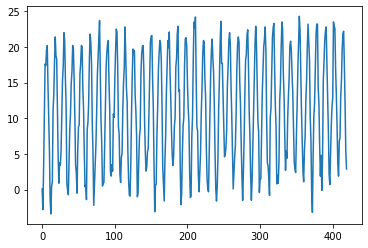

In [10]:
plt.plot(temp_lj['TEMPERATURA'])

(7.626666666666667, 14.610000000000003)

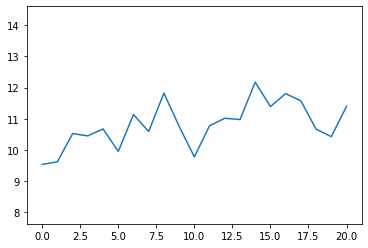

In [13]:
T = temp_lj['TEMPERATURA']
Tplot = np.array([np.average(T[k*12:(k+1)*12]) for k in range(21)])
plt.plot(Tplot)
plt.ylim(min(Tplot)*0.8, 1.2*max(Tplot))